In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf
import yfinance as yf

In [98]:
# Pulls daily adjusted close prices for one ticker. Returns: date, price, ticker
def get_daily_prices(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    df = df.reset_index()
    df = df.rename(columns={"Date": "date"})

    if "Adj Close" in df.columns:
        df["price"] = df["Adj Close"]
    else:
        df["price"] = df["Close"]

    df["ticker"] = ticker
    return df[["date", "price", "ticker"]]


def get_prices(tickerlist, start, end):
    frames = []
    for ticker in tickerlist:
        frames.append(get_daily_prices(ticker, start, end))
    return pd.concat(frames, ignore_index=True)

def run_diff_in_diff(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)

    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)]

    df = df.copy()
    df.loc[:, 'treated'] = np.where(df['ticker'] == treated, 1, 0)
    df.loc[:, 'post'] = np.where(df['date'] >= event_date, 1, 0)
    df.loc[:, 'treated_post'] = df['treated'] * df['post']


    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula=formula, data=df).fit()

    return model


def difference_in_trends (df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)

    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)]

    df['treated'] = np.where(df['ticker'] == treated, 1, 0)
    df['trend'] = (event_date - df['date']).dt.days
    df['treated_trend'] = df['treated'] * df['trend']
    
    formula = "returns ~ treated + trend + treated_trend"
    model = smf.ols(formula=formula, data=df).fit()

    return model

In [100]:
start_date = '2025-04-18'
end_date   = '2025-12-12'

event_date = pd.to_datetime('2025-10-16')

tickerlist = [
    "FFIV",   # treated (F5 Networks)
    "AKAM",   # Akamai – closest competitor in CDN + WAF
    "NET",    # Cloudflare – modern WAF + load balancing + edge security
    "FTNT",   # Fortinet – network security + firewalls
    "PANW",   # Palo Alto Networks – security + cloud firewalls
    "CSCO",   # Cisco – enterprise networking + load balancing/security
    "CHKP",   # Check Point Software – network firewalls, legacy competitor
    "CRWD",   # CrowdStrike – cloud security, XDR
    "ZS",     # Zscaler – zero-trust cloud access platform

    # Market controls
    "SPY",    # S&P 500 ETF – broad market benchmark
    "VTI"     # Total U.S. stock market ETF – full market control
]
prices.columns = prices.columns.get_level_values(0)


In [ ]:
prices = get_prices(tickerlist, start_date, end_date)

prices = prices.sort_values(["ticker", "date"])
prices["returns"] = prices.groupby("ticker")["price"].pct_change()

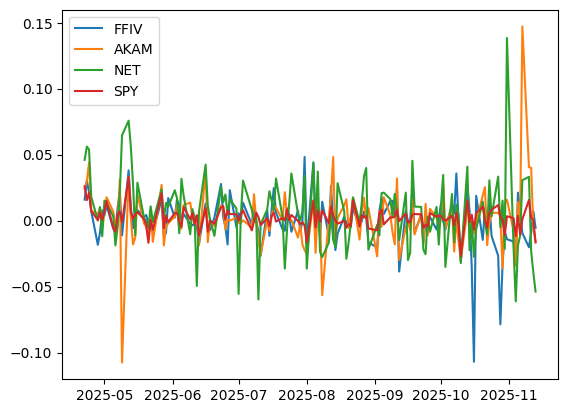

In [102]:
# Drop missing values and plot
ffiv=prices[prices['ticker'] == 'FFIV']
akam=prices[prices['ticker'] == 'AKAM']
spy=prices[prices['ticker'] == 'SPY']
net=prices[prices['ticker'] == 'NET']

plt.plot(ffiv['date'], ffiv['returns'], label='FFIV')
plt.plot(akam['date'], akam['returns'], label='AKAM')
plt.plot(net['date'],  net['returns'], label='NET')
plt.plot(spy['date'],  spy['returns'], label='SPY')

plt.legend()
plt.show()


In [103]:
ffiv_after = prices[(prices['ticker'] == 'FFIV') & (prices['date'] >= event_date)]
ffiv_after.head(10)


Price,date,price,ticker,returns
Ticker,,,,
124,2025-10-16,295.350006,FFIV,-0.107029
125,2025-10-17,300.899994,FFIV,0.018791
126,2025-10-20,296.500000,FFIV,-0.014623
127,2025-10-21,299.209991,FFIV,0.009140
128,2025-10-22,297.839996,FFIV,-0.004579
129,2025-10-23,301.859985,FFIV,0.013497
130,2025-10-24,298.339996,FFIV,-0.011661
131,2025-10-27,290.410004,FFIV,-0.026580
132,2025-10-28,267.579987,FFIV,-0.078613


Estimate the Difference-in-Difference Model

In [104]:
event_date = pd.to_datetime('2025-10-16')
treated = 'FFIV'

model = run_diff_in_diff(prices, event_date, treated)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     12.31
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           5.98e-08
Time:                        17:10:30   Log-Likelihood:                 3467.2
No. Observations:                1364   AIC:                            -6926.
Df Residuals:                    1360   BIC:                            -6905.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0021      0.001      3.918   

Assumptions

Assumption 1: Parallel Trends

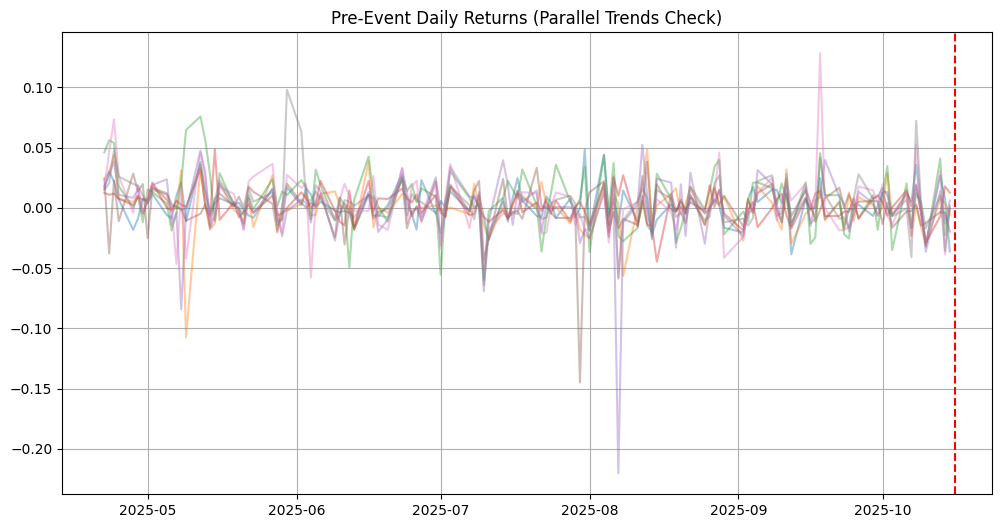

In [105]:
pre_event = prices[prices['date'] < event_date]

plt.figure(figsize=(12,6))

for t in ["FFIV", "AKAM", "NET", "CSCO", "FTNT", "CHKP", "CRWD", "ZS"]:
    se = pre_event[pre_event['ticker']==t]
    plt.plot(se['date'], se['returns'], alpha=0.4)

plt.title("Pre-Event Daily Returns (Parallel Trends Check)")
plt.axvline(event_date, color='red', linestyle='--')
plt.grid(True)
plt.show()


Assumption 2: No Anticipation (no pre-leak reaction)

In [109]:
placebo_date = event_date - pd.Timedelta(days=7)

model_placebo = run_diff_in_diff(prices, placebo_date, "FFIV")
print(model_placebo.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5361
Date:                Thu, 13 Nov 2025   Prob (F-statistic):              0.658
Time:                        17:17:17   Log-Likelihood:                 3331.1
No. Observations:                1309   AIC:                            -6654.
Df Residuals:                    1305   BIC:                            -6633.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0025      0.001      4.467   

Results show that in the pre preiod we have no evidence that theres any differnece in trend and so no reason to believe that it would change afterwards.

No differnce in trends prior to the event

In [110]:
test_trend_model = difference_in_trends(prices, event_date, "FFIV")
print(test_trend_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     7.864
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           3.33e-05
Time:                        17:18:07   Log-Likelihood:                 3460.6
No. Observations:                1364   AIC:                            -6913.
Df Residuals:                    1360   BIC:                            -6892.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0022      0.001     -2.044

C:\Users\Nick\AppData\Local\Temp\ipykernel_24828\2815444381.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treated'] = np.where(df['ticker'] == treated, 1, 0)
C:\Users\Nick\AppData\Local\Temp\ipykernel_24828\2815444381.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trend'] = (event_date - df['date']).dt.days
C:\Users\Nick\AppData\Local\Temp\ipykernel_24828\2815444381.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde